In [11]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [12]:
# Function to balance the dataset using binning and resampling
def balance_data(df, target_col):
    # Bin the target column
    df['Life_expectancy_bin'] = pd.cut(df[target_col], bins=np.arange(40, 90, 5))
    balanced_data = pd.DataFrame()

    # Resample each bin to balance the dataset
    for life_bin in df['Life_expectancy_bin'].unique():
        bin_data = df[df['Life_expectancy_bin'] == life_bin]
        if len(bin_data) > 0:
            bin_sample = resample(bin_data, replace=True, n_samples=100, random_state=1)
            balanced_data = pd.concat([balanced_data, bin_sample])

    balanced_data.drop(columns=['Life_expectancy_bin'], inplace=True)
    return balanced_data

In [13]:
# Function for feature engineering
def feature_engineer(df):
    # Drop 'Infant_deaths' due to high VIF
    df.drop(columns=['Infant_deaths'], inplace=True)

    # Combine Economy status
    df.rename(columns={'Economy_status_Developed': 'Development_status'}, inplace=True)
    df.drop(columns=['Economy_status_Developing'], inplace=True)

    # Combine Vaccination features
    df['Vaccination_Polio_Diphteria_Hepatitis_B'] = df['Polio'] + df['Diphtheria'] + df['Hepatitis_B']
    df.drop(columns=['Polio', 'Diphtheria', 'Hepatitis_B'], inplace=True)

    # Combine Thinness features
    df['Thinness'] = df['Thinness_ten_nineteen_years'] + df['Thinness_five_nine_years']
    df.drop(columns=['Thinness_ten_nineteen_years', 'Thinness_five_nine_years'], inplace=True)

    # Combine Mortality features
    df['Mortality'] = df['Under_five_deaths'] + df['Adult_mortality']
    df.drop(columns=['Under_five_deaths', 'Adult_mortality'], inplace=True)
    return df

In [14]:
# Function to train and evaluate the SVR model
def train_and_evaluate_svr(X, y):
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the SVR model
    svr_model = SVR(kernel='rbf', C=1000, gamma='scale', epsilon=0.01)
    svr_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svr_model.predict(X_test_scaled)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation metrics
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

    # Visualization: Actual vs Predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, color='skyblue', marker='o', label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, color='orange', marker='x', label='Predicted')
    plt.title('SVR: Actual vs Predicted Life Expectancy')
    plt.xlabel('Sample Index')
    plt.ylabel('Life Expectancy')
    plt.ylim(30, 90)
    plt.legend()
    plt.grid(True)
    plt.show()


Results for Original Dataset
MAE: 0.2538, MSE: 0.1796, R²: 0.9979


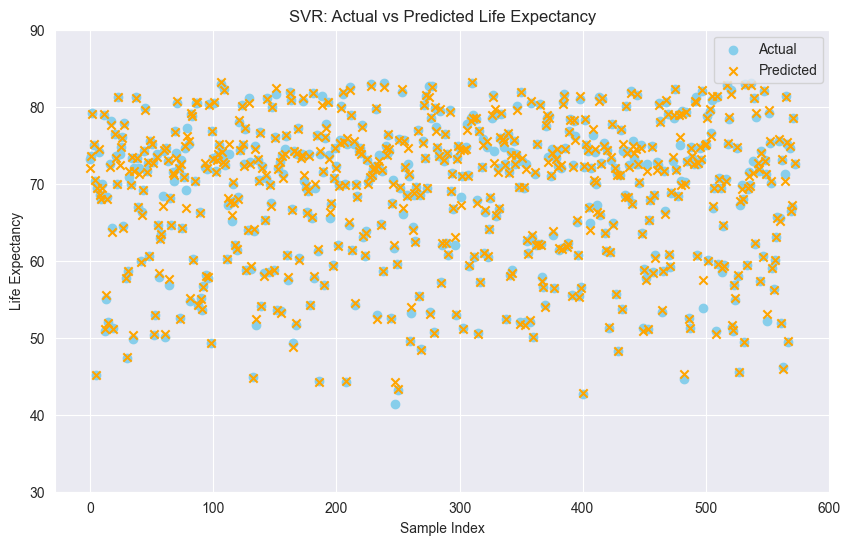

Results for Original Dataset with Balanced Data
MAE: 0.4417, MSE: 0.6022, R²: 0.9964


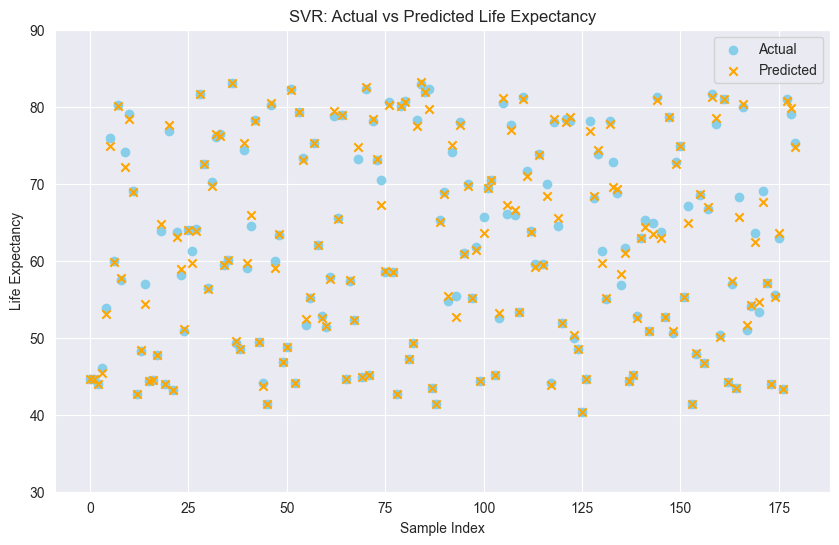


Results for Feature-Engineered Dataset with Balanced Data
MAE: 0.4397, MSE: 0.7123, R²: 0.9957


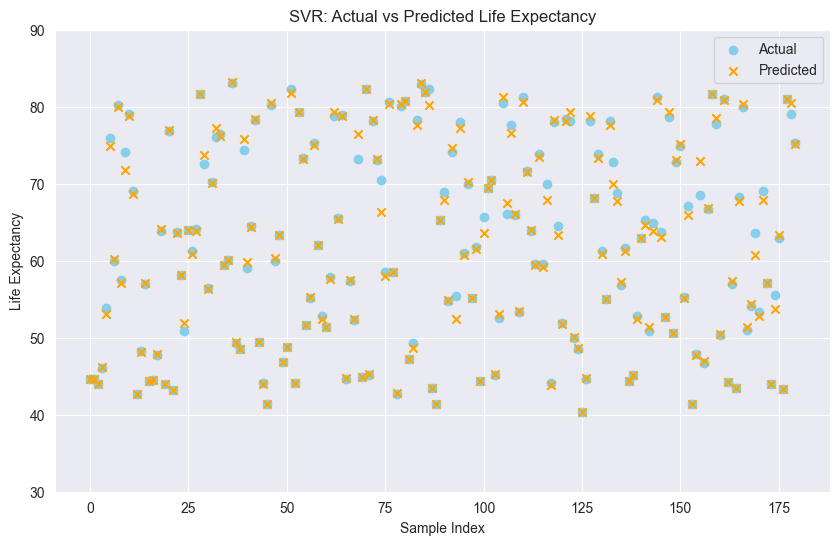

In [15]:
# Load and preprocess the data
df = pd.read_csv('../data/data.csv')
df_original = df.copy()

# Train model on the original dataset
print("Results for Original Dataset")
X = df_original.drop(columns=['Life_expectancy', 'Country', 'Year', 'Region'])
y = df_original['Life_expectancy']
train_and_evaluate_svr(X, y)

# Train model on the original balanced dataset
print("Results for Original Dataset with Balanced Data")
balanced_data = balance_data(df_original, 'Life_expectancy')
X_original = balanced_data.drop(columns=['Life_expectancy', 'Country', 'Year', 'Region'])
y_original = balanced_data['Life_expectancy']
train_and_evaluate_svr(X_original, y_original)

# Train model on the feature-engineered dataset
print("\nResults for Feature-Engineered Dataset with Balanced Data")
df_fe = feature_engineer(df.copy())
balanced_data_fe = balance_data(df_fe, 'Life_expectancy')
X_fe = balanced_data_fe.drop(columns=['Life_expectancy', 'Country', 'Year', 'Region'])
y_fe = balanced_data_fe['Life_expectancy']
train_and_evaluate_svr(X_fe, y_fe)